before trimming, 17619 total jobs, 1632 vm jobs from 491 vm hosts, and 15987 native jobs from 1659 native hosts
after trimming, 15223 total jobs, 802 vm jobs from 201 vm hosts, and 14421 native jobs from 1254 native hosts


/usr/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


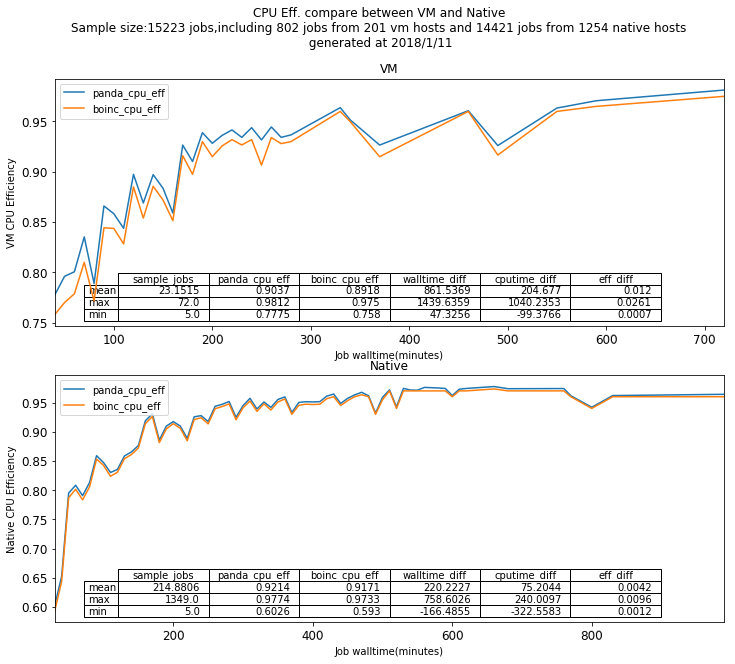

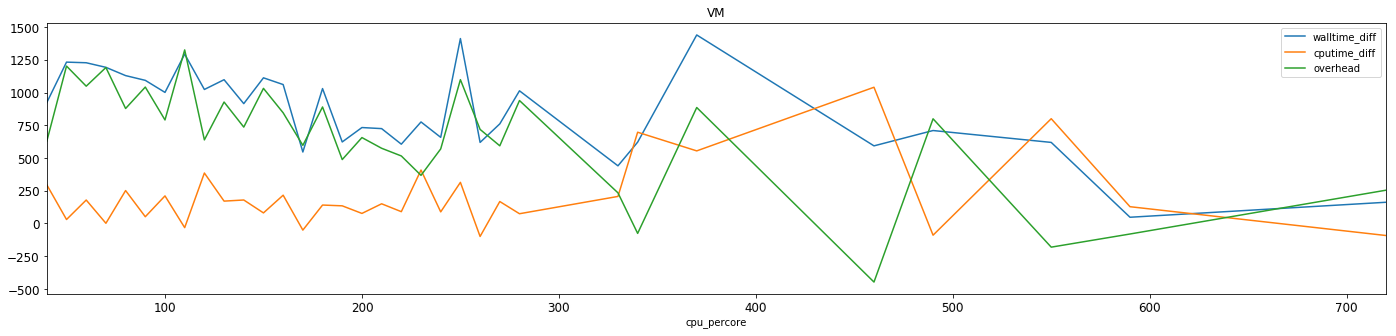

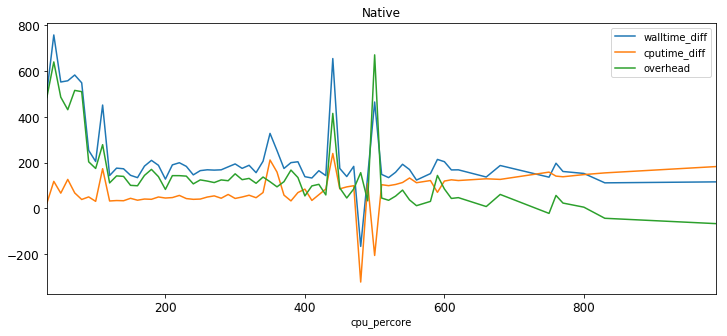

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
import time


def get_summary_df(df):
    dfd=df.describe()
    
    tmp=[dfd["mean":"mean"],dfd["max":"max"],dfd["min":"min"]]
    dfx=pd.concat(tmp)
    dfx=dfx.applymap(lambda x:np.round(x,4))
    return dfx
    
l=time.localtime()[0:3]
today="/".join(map(str,l))

df=pd.read_csv("boinc_perf.csv")
del df["taskid"]
#print(df.describe())
df["cpu_percore"]=(df["panda_cpusec_perjob"]/(df["ncore"]*600))
df["cpu_percore"]=df["cpu_percore"].map(int)
df["av"]=df["av"].map(lambda x: "native" if x==478 else "vm")
jobs_total=df["boinc_cn"].sum()
hosts_native=len(df[df["av"]=="native"].values)
hosts_vm=len(df[df["av"]=="vm"].values)
jobs_native=df[df["av"]=="native"]["boinc_cn"].sum()
jobs_vm=jobs_total-jobs_native
print("before trimming, %d total jobs, %d vm jobs from %d vm hosts, and %d native jobs from %d native hosts"\
      %(jobs_total,jobs_vm,hosts_vm,jobs_native,hosts_native))


#print(df["av"].values)
df.set_index("cpu_percore")
df=df.sort_index()

#df=df[(df["panda_cpu_eff"]-df["boinc_cpu_eff"])<=0.5/df["cpu_percore"]]
#df=df[df["boinc_cn"]==df["panda_cn"]]
#df=df[(df["cputime_diff"]>0) & (df["walltime_diff"]>0)]
df=df[(df["cputime_diff"]<3600) & (df["walltime_diff"]<3600)]

del df['Unnamed: 0']
del df["host"]
del df["ncore"]
del df["panda_cpusec_perjob"]
df=df[df["boinc_cpu_eff"]<df["panda_cpu_eff"]]
df=df.sort_values(by=["cpu_percore","av"])
jobs_total=df["boinc_cn"].sum()
hosts_native=len(df[df["av"]=="native"].values)
hosts_vm=len(df[df["av"]=="vm"].values)
jobs_native=df[df["av"]=="native"]["boinc_cn"].sum()
jobs_vm=jobs_total-jobs_native
print("after trimming, %d total jobs, %d vm jobs from %d vm hosts, and %d native jobs from %d native hosts"\
      %(jobs_total,jobs_vm,hosts_vm,jobs_native,hosts_native))
#print(df[df["cpu_percore"]==0])




dlist=[]
grouped=df.groupby(["av","cpu_percore"])
for name,group in grouped:
    g=group[["panda_cpu_eff","boinc_cpu_eff","job_cpu_eff","walltime_diff","cputime_diff"]].mean()
    s=group[["panda_cn","boinc_cn"]].sum()
    d=[]
    for i in name:
        if i not in ["vm","native"]:
            cpu_percore=i
        else:
            type=i
    if s["panda_cn"]<5 or s["boinc_cn"]<5:
        continue
    d=[type,cpu_percore,s["panda_cn"],g["panda_cpu_eff"],g["boinc_cpu_eff"],g["job_cpu_eff"],g["walltime_diff"],g["cputime_diff"]]
    dlist.append(d)

head=["type","cpu_percore","sample_jobs","panda_cpu_eff","boinc_cpu_eff","job_cpu_eff","walltime_diff","cputime_diff"]
df2=pd.DataFrame(dlist,columns=head)
df2=df2.sort_values(by=["cpu_percore"]).set_index("cpu_percore")

grouped=df2.groupby(["type","cpu_percore"])
dlist=[]
for name,group in grouped:
    d=[]
    for i in name:
        d.append(i)
    g=group[["panda_cpu_eff","boinc_cpu_eff","job_cpu_eff","walltime_diff","cputime_diff"]].mean()
    total_jobs=group[["sample_jobs"]].sum()["sample_jobs"]
    d.append(total_jobs)
    d.append(g["panda_cpu_eff"])
    d.append(g["boinc_cpu_eff"])
    d.append(g["job_cpu_eff"])
    d.append(g["walltime_diff"])
    d.append(g["cputime_diff"])
    
    dlist.append(d)

df3=pd.DataFrame(dlist,columns=head)
df3["cpu_percore"]=df3["cpu_percore"].map(lambda x:x*10)
df3.sort_values(by=["cpu_percore"])
del df3["job_cpu_eff"]

df_native=df3[df3["type"]=="native"]
df_vm=df3[df3["type"]=="vm"]


df6=df_native.copy()
df6["native_eff"]=df6["boinc_cpu_eff"]
del df6["boinc_cpu_eff"]
del df6["panda_cpu_eff"]
del df6["type"]
df7=df_vm.copy()
df7["vm_eff"]=df7["boinc_cpu_eff"]
del df7["boinc_cpu_eff"]
del df7["panda_cpu_eff"]
del df7["type"]
df_merge=df6.merge(df7,on="cpu_percore",how="inner")
df_merge["eff_diff"]=df_merge["native_eff"]-df_merge["vm_eff"]
df_merge=df_merge.set_index("cpu_percore")


df_native=df_native.set_index("cpu_percore")
df_vm=df_vm.set_index("cpu_percore")
df_native["eff_diff"]=df_native["panda_cpu_eff"]-df_native["boinc_cpu_eff"]
df_vm["eff_diff"]=df_vm["panda_cpu_eff"]-df_vm["boinc_cpu_eff"]


dfes=[df_vm,df_native]
#print(df_vm)
#print(df_native)
#print(get_summary_df(dfes[0]))
fig, axes = plt.subplots(2,1)

plt.suptitle("CPU Eff. compare between VM and Native\nSample size:%d jobs,including %d jobs from %d vm hosts and %d jobs \
from %d native hosts\n generated at %s"%(jobs_total,jobs_vm,hosts_vm,jobs_native,hosts_native,today))
for i in [0,1]:
    tag="Native"
    if i==0:
        tag="VM"
    dfes[i][["panda_cpu_eff","boinc_cpu_eff"]].plot(ax=axes[i],kind="line",grid=False,figsize=(12,10),\
                                                    rot=1,fontsize=12,title=tag,alpha=1)
    table(axes[i],get_summary_df(dfes[i]),loc="lower center",colWidths=[0.135]*len(dfes[i].columns),fontsize=12)
    axes[i].set_xlabel("Job walltime(minutes)")
    axes[i].set_ylabel("%s CPU Efficiency"%tag)
    plt.legend(loc="upper left")
    #ax.get_xaxis().set_visible(False)

fig.savefig("boinc_native_perf.png")
df_vm["overhead"]=df_vm["walltime_diff"]-df_vm["cputime_diff"]
df_native["overhead"]=df_native["walltime_diff"]-df_native["cputime_diff"]
df_vm[["walltime_diff","cputime_diff","overhead"]].plot(kind="line",grid=False,figsize=(24,5),rot=1,fontsize=12,title="VM",alpha=1)
df_native[["walltime_diff","cputime_diff","overhead"]].plot(kind="line",grid=False,figsize=(12,5),\
                rot=1,fontsize=12,title="Native",alpha=1)


In [2]:
left = pd.DataFrame({'A': ['A0', 'A1', 'A2'], 'B': ['B0', 'B1', 'B2']},index=['K0', 'K1', 'K2'])
right = pd.DataFrame({'C': ['A0', 'A1', 'A2'], 'D': ['B0', 'B1', 'B2']},index=['K0', 'K4','K2'])
print(left)
print(right)
left.join(right,how="outer")

     A   B
K0  A0  B0
K1  A1  B1
K2  A2  B2
     C   D
K0  A0  B0
K4  A1  B1
K2  A2  B2


,A,B,C,D
K0,A0,B0,A0,B0
K1,A1,B1,NaN,NaN
K2,A2,B2,A2,B2
K4,NaN,NaN,A1,B1
